## Change sys.path to use my tensortrade instead of the one in env

In [1]:
import sys
import os
# sys.path.append("/Users/jasonfiacco/Documents/Yale/Senior/thesis/deeptrader")
# sys.path.append("/Users/jasonfiacco/Documents/Yale/Senior/thesis/deeptrader/GetOldTweets")
sys.path.append(os.path.realpath(".."))
sys.path.append(os.path.realpath("../GetOldTweets"))
print(sys.path)

['/home/accts/jcf73/thesis/deeptrader/examples', '/home/accts/jcf73/thesis/venv/lib64/python37.zip', '/home/accts/jcf73/thesis/venv/lib64/python3.7', '/home/accts/jcf73/thesis/venv/lib64/python3.7/lib-dynload', '/usr/lib64/python3.7', '/usr/lib/python3.7', '', '/home/accts/jcf73/thesis/venv/lib/python3.7/site-packages', '/home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/IPython/extensions', '/home/accts/jcf73/.ipython', '/home/accts/jcf73/thesis/deeptrader', '/home/accts/jcf73/thesis/deeptrader/GetOldTweets']


## Fetch the Labeled PredictIt Data  
Adds ALL TA features at first. Also creates the "price_norm" metric which is close/open.

In [2]:
import ssl
import pandas as pd
import ta
from datetime import datetime, timedelta

ssl._create_default_https_context = ssl._create_unverified_context # Only used if pandas gives a SSLError

def fetch_data(symbol):
    path = "../predictit_datasets/"
    filename = "{}_labeled.csv".format(symbol)

    df = pd.read_csv(path + filename)
    
    df = df.set_index("Date")


    return df

In [3]:
all_data = pd.concat([
    fetch_data("WARREN"),
    fetch_data("CRUZ"),
    fetch_data("MANCHIN"),
    fetch_data("SANDERS"),
    fetch_data("NELSON"),
    fetch_data("DONNELLY"),
    fetch_data("PELOSI"),
    fetch_data("MANAFORT"),
    fetch_data("BROWN"),
    fetch_data("RYAN"),
    fetch_data("STABENOW"),
    fetch_data("KNIGHT"),
    fetch_data("MCCASKILL"),
    fetch_data("BALDWIN"),
    fetch_data("DENHAM"),
    fetch_data("HEITKAMP"),
    fetch_data("TESTER"),
    fetch_data("HURD"),
    fetch_data("HEINRICH"),
    fetch_data("MENENDEZ")
], axis=1)
all_data.head()

,WARREN:open,WARREN:low,WARREN:high,WARREN:close,WARREN:volume,WARREN:average,WARREN:price_norm,WARREN:current_date,WARREN:sentiment,WARREN:volume_adi,...,MENENDEZ:momentum_uo,MENENDEZ:momentum_stoch,MENENDEZ:momentum_stoch_signal,MENENDEZ:momentum_wr,MENENDEZ:momentum_ao,MENENDEZ:momentum_kama,MENENDEZ:momentum_roc,MENENDEZ:others_dr,MENENDEZ:others_dlr,MENENDEZ:others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,0.81,0.79,0.82,0.80,768,0.8067,0.987654,2017-02-01,0.04693,-256.0,...,NaN,7.142857,7.142857,-92.857143,0.0,NaN,NaN,-4.508748,NaN,0.0
2017-02-02,0.80,0.79,0.80,0.79,50,0.7996,0.987500,2017-02-02,0.05167,-306.0,...,NaN,7.142857,7.142857,-92.857143,0.0,NaN,NaN,0.000000,0.0,0.0
2017-02-03,0.79,0.78,0.80,0.78,592,0.7813,0.987342,2017-02-03,0.07868,-898.0,...,NaN,7.142857,7.142857,-92.857143,0.0,NaN,NaN,0.000000,0.0,0.0
2017-02-04,0.78,0.78,0.79,0.79,10,0.7900,1.012821,2017-02-04,0.14822,-888.0,...,NaN,7.142857,7.142857,-92.857143,0.0,NaN,NaN,0.000000,0.0,0.0
2017-02-05,0.79,0.79,0.80,0.80,6,0.7950,1.012658,2017-02-05,-0.01526,-882.0,...,NaN,7.142857,7.142857,-92.857143,0.0,NaN,NaN,0.000000,0.0,0.0


## Plot the closing prices for all the markets

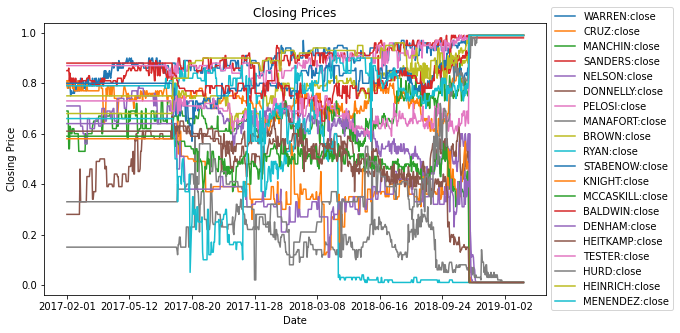

In [4]:
import matplotlib.pyplot as plt
closing_prices = all_data.loc[:, [("close" in name) for name in all_data.columns]]
closing_prices.plot(figsize=(9, 5))
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Closing Prices")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

In [5]:
#Copy it over cause of variable names
subset_data = all_data

## Define The Exchange

An exchange needs a name, an execution service, and streams of price data in order to function properly.

The setups supported right now are the simulated execution service using simulated or stochastic data. More execution services will be made available in the future, as well as price streams so that live data and execution can be supported.

In [6]:
from tensortrade.exchanges import Exchange
from tensortrade.exchanges.services.execution.simulated import execute_order
from tensortrade.data import Stream

#Exchange(name of exchange, service)
#It looks like each Stream takes a name, and then a list of the closing prices.

predictit_exch = Exchange("predictit", service=execute_order)(
    Stream("USD-WARREN", list(subset_data['WARREN:close'])),
    Stream("USD-CRUZ", list(subset_data['CRUZ:close'])),
    Stream("USD-MANCHIN", list(subset_data['MANCHIN:close'])),
    Stream("USD-SANDERS", list(subset_data['SANDERS:close'])),
    Stream("USD-NELSON", list(subset_data['NELSON:close'])),
    Stream("USD-DONNELLY", list(subset_data['DONNELLY:close'])),
    Stream("USD-PELOSI", list(subset_data['PELOSI:close'])),
    Stream("USD-MANAFORT", list(subset_data['MANAFORT:close'])),
    Stream("USD-BROWN", list(subset_data['BROWN:close'])),
    Stream("USD-RYAN", list(subset_data['RYAN:close'])),
    Stream("USD-STABENOW", list(subset_data['STABENOW:close'])),
    Stream("USD-KNIGHT", list(subset_data['KNIGHT:close'])),
    Stream("USD-MCCASKILL", list(subset_data['MCCASKILL:close'])),
    Stream("USD-BALDWIN", list(subset_data['BALDWIN:close'])),
    Stream("USD-DENHAM", list(subset_data['DENHAM:close'])),
    Stream("USD-HEITKAMP", list(subset_data['HEITKAMP:close'])),
    Stream("USD-TESTER", list(subset_data['TESTER:close'])),
    Stream("USD-HURD", list(subset_data['HURD:close'])),
    Stream("USD-HEINRICH", list(subset_data['HEINRICH:close'])),
    Stream("USD-MENENDEZ", list(subset_data['MENENDEZ:close']))
)

Now that the exchanges have been defined we can define our features that we would like to include, excluding the prices we have provided for the exchanges.

## Defint the "Portfolio"

Make the portfolio using the any combinations of exchanges and intruments that the exchange supports

In [7]:
#I am going to have to add "instruments" for all 25 of the PredictIt markets I'm working with.
from tensortrade.instruments import USD, WARREN, CRUZ, MANCHIN, SANDERS, NELSON, DONNELLY,\
                                PELOSI, MANAFORT, BROWN, RYAN, STABENOW, KNIGHT, MCCASKILL, \
                                BALDWIN, DENHAM, HEITKAMP, TESTER, HURD, HEINRICH, MENENDEZ
from tensortrade.wallets import Wallet, Portfolio

portfolio = Portfolio(USD, [
    Wallet(predictit_exch, 10000000 * USD),
    Wallet(predictit_exch, 0 * WARREN),
    Wallet(predictit_exch, 0 * CRUZ),
    Wallet(predictit_exch, 0 * MANCHIN),
    Wallet(predictit_exch, 0 * SANDERS),
    Wallet(predictit_exch, 0 * NELSON),
    Wallet(predictit_exch, 0 * DONNELLY),
    Wallet(predictit_exch, 0 * PELOSI),
    Wallet(predictit_exch, 0 * MANAFORT),
    Wallet(predictit_exch, 0 * BROWN),
    Wallet(predictit_exch, 0 * RYAN),
    Wallet(predictit_exch, 0 * STABENOW),
    Wallet(predictit_exch, 0 * KNIGHT),
    Wallet(predictit_exch, 0 * MCCASKILL),
    Wallet(predictit_exch, 0 * BALDWIN),
    Wallet(predictit_exch, 0 * DENHAM),
    Wallet(predictit_exch, 0 * HEITKAMP),
    Wallet(predictit_exch, 0 * TESTER),
    Wallet(predictit_exch, 0 * HURD),
    Wallet(predictit_exch, 0 * HEINRICH),
    Wallet(predictit_exch, 0 * MENENDEZ)
])

## Create a feature dataframe that specifies custom features

In [8]:
#Select only the TA features to keep
features_to_keep = ["close", "sentiment", "volume", "trend_cci", "momentum_rsi"]
feature_data = subset_data.loc[:, [(any(word in name for word in features_to_keep)) for name in subset_data.columns]]

#Remove any extra volume columns
feature_data = feature_data[feature_data.columns.drop(list(feature_data.filter(regex='volume_')))]

feature_data

,WARREN:close,WARREN:volume,WARREN:sentiment,WARREN:trend_cci,WARREN:momentum_rsi,CRUZ:close,CRUZ:volume,CRUZ:sentiment,CRUZ:trend_cci,CRUZ:momentum_rsi,...,HEINRICH:close,HEINRICH:volume,HEINRICH:sentiment,HEINRICH:trend_cci,HEINRICH:momentum_rsi,MENENDEZ:close,MENENDEZ:volume,MENENDEZ:sentiment,MENENDEZ:trend_cci,MENENDEZ:momentum_rsi
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,0.80,768,0.04693,NaN,100.000000,0.81,1411,0.21082,NaN,100.000000,...,0.75,0,0.24841,NaN,100.000000,0.66,0,0.036070,NaN,100.000000
2017-02-02,0.79,50,0.05167,-66.666667,0.000000,0.78,924,0.06047,-66.666667,0.000000,...,0.75,0,0.43215,NaN,100.000000,0.66,0,-0.033775,NaN,100.000000
2017-02-03,0.78,592,0.07868,-87.500000,0.000000,0.81,25,0.14213,-33.333333,51.851852,...,0.75,0,0.03893,NaN,100.000000,0.66,0,0.011211,NaN,100.000000
2017-02-04,0.79,10,0.14822,-66.666667,35.831810,0.81,27,-0.05324,-30.769231,51.851852,...,0.75,0,0.01821,NaN,100.000000,0.66,0,0.000000,NaN,100.000000
2017-02-05,0.80,6,-0.01526,41.666667,53.698630,0.81,1,-0.12315,27.027027,51.851852,...,0.75,0,0.11472,NaN,100.000000,0.66,0,0.013943,NaN,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-28,0.99,0,-0.20105,166.666667,62.938371,0.99,0,0.17329,-166.666667,82.765969,...,0.99,0,-0.32189,600.0,68.170813,0.99,0,0.088950,333.333333,71.912774
2019-01-29,0.99,0,0.24873,166.666667,62.938371,0.99,0,-0.23346,-166.666667,82.765969,...,0.99,0,-0.23839,600.0,68.170813,0.99,0,-0.132570,333.333333,71.912774
2019-01-30,0.99,0,-0.04311,166.666667,62.938371,0.99,0,-0.04381,-166.666667,82.765969,...,0.99,0,0.02141,600.0,68.170813,0.99,0,-0.229600,333.333333,71.912774


In [9]:
#Make the time series stationary
import numpy as np

def get_log_and_diff(df, features):
    new_df = pd.DataFrame()

    #First handle close prices
    close_cols = [name for name in df.columns if any(word in name for word in ["close"]) ]
    for col in close_cols:
        new_df[col+"_diff"] = np.log(df[col]) - np.log(df[col].shift(1))

    cols_to_norm = [name for name in df.columns if any(word in name for word in features) ]
    for col in cols_to_norm:
        new_df[col+"_diff"] = df[col] - df[col].shift(1)

    return new_df
    

feature_data = get_log_and_diff(feature_data, ["volume", "sentiment", "trend_cci", "momentum_rsi"])


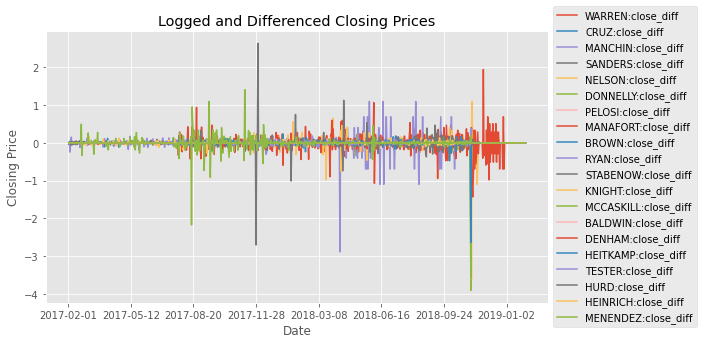

In [10]:
#Print the stationary prices.
closing_prices = feature_data.loc[:, [("close" in name) for name in feature_data.columns]]
closing_prices.plot(figsize=(9, 5))
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Logged and Differenced Closing Prices")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

In [11]:
#Replace all inf and -inf (which are in the trend_cci column) with Nan
import numpy as np
feature_data = feature_data.replace([np.inf, -np.inf, np.nan], 0)

In [12]:
#Normalize the technical features
features_to_norm = ["volume", "trend_cci", "momentum_rsi"]
cols_to_norm = [name for name in feature_data.columns if any(word in name for word in features_to_norm) ]
#feature_data[cols_to_norm] = feature_data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

from sklearn.preprocessing import StandardScaler
feature_data[cols_to_norm] = StandardScaler().fit_transform(feature_data[cols_to_norm])

#Fill any Nan in trend CCI with zeroes. (Do this AFTER normalization)
feature_data.loc[:, [("trend_cci" in name) for name in feature_data.columns]] = feature_data.loc[:, [("trend_cci" in name) for name in feature_data.columns]].fillna(value=0)


feature_data.head()

,WARREN:close_diff,CRUZ:close_diff,MANCHIN:close_diff,SANDERS:close_diff,NELSON:close_diff,DONNELLY:close_diff,PELOSI:close_diff,MANAFORT:close_diff,BROWN:close_diff,RYAN:close_diff,...,HURD:trend_cci_diff,HURD:momentum_rsi_diff,HEINRICH:volume_diff,HEINRICH:sentiment_diff,HEINRICH:trend_cci_diff,HEINRICH:momentum_rsi_diff,MENENDEZ:volume_diff,MENENDEZ:sentiment_diff,MENENDEZ:trend_cci_diff,MENENDEZ:momentum_rsi_diff
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004094,0.007581,0.0,0.00000,-0.011833,0.005665,0.0,0.000000,-0.002344,0.005679
2017-02-02,-0.012579,-0.03774,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004094,0.007581,0.0,0.18374,-0.011833,0.005665,0.0,-0.069845,-0.002344,0.005679
2017-02-03,-0.012739,0.03774,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004094,0.007581,0.0,-0.39322,-0.011833,0.005665,0.0,0.044986,-0.002344,0.005679
2017-02-04,0.012739,0.00000,-0.245122,0.011696,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004094,0.007581,0.0,-0.02072,-0.011833,0.005665,0.0,-0.011211,-0.002344,0.005679
2017-02-05,0.012579,0.00000,0.000000,-0.059898,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004094,0.007581,0.0,0.09651,-0.011833,0.005665,0.0,0.013943,-0.002344,0.005679


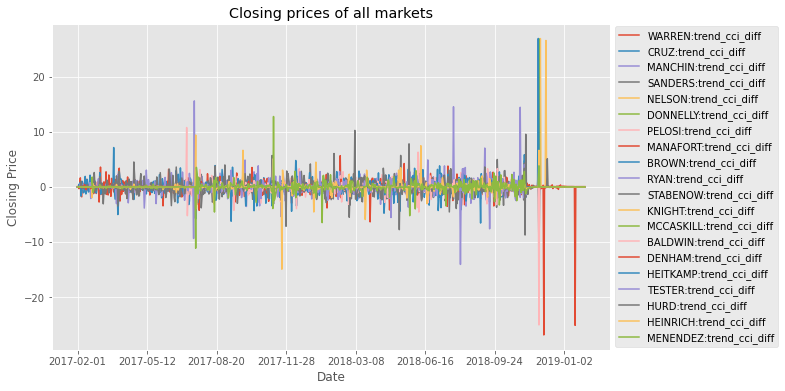

In [13]:
#Plot again
to_plot = feature_data.loc[:, [("cci" in name) for name in feature_data.columns]]
to_plot.plot(figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Closing prices of all markets")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

## Split into train and test data

In [14]:
train_data = feature_data[(pd.to_datetime(feature_data.index)>= '02-01-2017') & (pd.to_datetime(feature_data.index) <= '08-01-2018')]
train_data.head(3)

,WARREN:close_diff,CRUZ:close_diff,MANCHIN:close_diff,SANDERS:close_diff,NELSON:close_diff,DONNELLY:close_diff,PELOSI:close_diff,MANAFORT:close_diff,BROWN:close_diff,RYAN:close_diff,...,HURD:trend_cci_diff,HURD:momentum_rsi_diff,HEINRICH:volume_diff,HEINRICH:sentiment_diff,HEINRICH:trend_cci_diff,HEINRICH:momentum_rsi_diff,MENENDEZ:volume_diff,MENENDEZ:sentiment_diff,MENENDEZ:trend_cci_diff,MENENDEZ:momentum_rsi_diff
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004094,0.007581,0.0,0.00000,-0.011833,0.005665,0.0,0.000000,-0.002344,0.005679
2017-02-02,-0.012579,-0.03774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004094,0.007581,0.0,0.18374,-0.011833,0.005665,0.0,-0.069845,-0.002344,0.005679
2017-02-03,-0.012739,0.03774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004094,0.007581,0.0,-0.39322,-0.011833,0.005665,0.0,0.044986,-0.002344,0.005679


In [15]:
test_data = feature_data[(pd.to_datetime(feature_data.index) >= '08-02-2018') & (pd.to_datetime(feature_data.index) <= '11-01-2018')]
test_data.head(3)

,WARREN:close_diff,CRUZ:close_diff,MANCHIN:close_diff,SANDERS:close_diff,NELSON:close_diff,DONNELLY:close_diff,PELOSI:close_diff,MANAFORT:close_diff,BROWN:close_diff,RYAN:close_diff,...,HURD:trend_cci_diff,HURD:momentum_rsi_diff,HEINRICH:volume_diff,HEINRICH:sentiment_diff,HEINRICH:trend_cci_diff,HEINRICH:momentum_rsi_diff,MENENDEZ:volume_diff,MENENDEZ:sentiment_diff,MENENDEZ:trend_cci_diff,MENENDEZ:momentum_rsi_diff
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-02,0.000000,-0.028171,0.012579,0.0,-0.019048,0.108214,-0.01105,-0.344840,0.000000,0.0,...,0.608340,0.007581,0.0,0.13148,0.410237,0.005665,0.023595,0.27210,-0.674715,-0.623374
2018-08-03,0.010471,0.014185,-0.012579,0.0,0.000000,0.000000,0.00000,0.211309,0.000000,0.0,...,0.278707,-1.001663,0.0,0.11967,0.268253,0.005665,0.009295,-0.29159,-0.310229,0.005679
2018-08-04,-0.021053,0.013986,-0.038715,0.0,-0.039221,0.025318,0.00000,0.000000,0.011834,0.0,...,0.655166,0.007581,0.0,-0.38118,0.186140,0.005665,-0.049097,-0.05636,1.377321,1.035362


### Now make the "External Data Feed" objects

In [16]:
#Add "Streams" for all my external added features.
from tensortrade.data import DataFeed, Module

#Do it for train set
with Module("predictit") as train_predictit_ns:
    train_predictit_nodes = [Stream(name, list(train_data[name])) for name in train_data.columns]
    
#Now do it for test set
with Module("predictit") as test_predictit_ns:
    test_predictit_nodes = [Stream(name, list(test_data[name])) for name in test_data.columns]

In [17]:
#Then create the train Feed from it
train_external_feed = DataFeed([train_predictit_ns])
test_external_feed = DataFeed([test_predictit_ns])
train_external_feed.next()

{'predictit:/WARREN:close_diff': 0.0,
 'predictit:/CRUZ:close_diff': 0.0,
 'predictit:/MANCHIN:close_diff': 0.0,
 'predictit:/SANDERS:close_diff': 0.0,
 'predictit:/NELSON:close_diff': 0.0,
 'predictit:/DONNELLY:close_diff': 0.0,
 'predictit:/PELOSI:close_diff': 0.0,
 'predictit:/MANAFORT:close_diff': 0.0,
 'predictit:/BROWN:close_diff': 0.0,
 'predictit:/RYAN:close_diff': 0.0,
 'predictit:/STABENOW:close_diff': 0.0,
 'predictit:/KNIGHT:close_diff': 0.0,
 'predictit:/MCCASKILL:close_diff': 0.0,
 'predictit:/BALDWIN:close_diff': 0.0,
 'predictit:/DENHAM:close_diff': 0.0,
 'predictit:/HEITKAMP:close_diff': 0.0,
 'predictit:/TESTER:close_diff': 0.0,
 'predictit:/HURD:close_diff': 0.0,
 'predictit:/HEINRICH:close_diff': 0.0,
 'predictit:/MENENDEZ:close_diff': 0.0,
 'predictit:/WARREN:volume_diff': 0.0007819890389761158,
 'predictit:/WARREN:sentiment_diff': 0.0,
 'predictit:/WARREN:trend_cci_diff': -0.0048507814974368055,
 'predictit:/WARREN:momentum_rsi_diff': 0.006612971143076447,
 'predi

## First Launch Ray. 
This is where you define our training "Trading Enviroment," which includes things such as the action scheme, the reward scheme, the window size, and whether or not to use the "interal feed" (internal data feed has all the price data from the wallets and the networth of the portfolio).

In [18]:
#Add the deeptrader path to ALL workers, not just the current worker
import os
parent_dir = os.path.realpath("..")
os.environ["PYTHONPATH"] = parent_dir + ":" + os.environ.get("PYTHONPATH", "")

In [19]:
#Try and get rid of that yaml warning (although this only does it for THIS worker)
import yaml
yaml.warnings({'YAMLLoadWarning': False})

In [20]:
# Environment
from tensortrade.environments import TradingEnvironment


import gym
import ray
from ray import tune
from ray.tune import grid_search
from ray.tune.registry import register_env

import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print
from tensortrade.rewards import RiskAdjustedReturns
    
class RayTradingEnv(TradingEnvironment):
    def __init__(self):        
        env = TradingEnvironment(
            feed=train_external_feed,
            portfolio=portfolio,
            action_scheme="simple",
            reward_scheme="diversified",
            window_size=15,
            enable_logger=False,
            renderers = 'screenlog',
            use_internal = False,
        ) 
        self.env = env
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        
        

    def reset(self):
        return self.env.reset()

    def step(self, action):
        return self.env.step(action)

def env_creator(env_config):
    return RayTradingEnv()

register_env("ray_trading_env", env_creator)


#ray.init(ignore_reinit_error=True, local_mode=True)

## Train using Tune

In [37]:
#Implement Custom neural network model
from ray.rllib.models import ModelCatalog
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.agents.dqn.distributional_q_model import DistributionalQModel
from ray.rllib.utils import try_import_tf

from ray.rllib.models.tf.fcnet_v2 import FullyConnectedNetwork

from gym.spaces import Box

tf = try_import_tf()

class CNNModel(DistributionalQModel, TFModelV2):
    """Custom model for DQN."""

    def __init__(self, obs_space, action_space, num_outputs, model_config,
                 name, **kw):
        super(CNNModel, self).__init__(
            obs_space, action_space, num_outputs, model_config, name, **kw)

#         # Define neural net layers
#         self.base_model = tf.keras.Sequential([
#             tf.keras.layers.InputLayer(input_shape=obs_space.shape),
#             tf.keras.layers.Conv1D(filters=40, kernel_size=6, padding="same", activation="relu"),
#             tf.keras.layers.MaxPooling1D(pool_size=2),
#             tf.keras.layers.Conv1D(filters=20, kernel_size=3, padding="same", activation="relu"),
#             tf.keras.layers.MaxPooling1D(pool_size=2),
#             tf.keras.layers.Flatten(),
#             tf.keras.layers.Dense(num_outputs, activation="softmax")
#         ])
        
    
    
        self.base_model = FullyConnectedNetwork(
            Box(np.finfo(np.float32).min, np.finfo(np.float32).max, shape=(15, 121)),
            action_space, 1, model_config, name+"_action_embed")
        
    
    
        self.register_variables(self.base_model.variables())

    # Implement the core forward method
    def forward(self, input_dict, state, seq_lens):
        model_out, _ = self.base_model({"obs": input_dict["obs"]["real_obs"]})

        
        avail_actions = input_dict["obs"]["avail_actions"]
        action_mask = input_dict["obs"]["action_mask"]
        
        intent_vector = tf.expand_dims(model_out, 1)
        
        action_logits = tf.reduce_sum(avail_actions * intent_vector, axis=2)
        
        inf_mask = tf.maximum(tf.log(action_mask), tf.float32.min)
        
        
        return action_logits + inf_mask, state
    
    def value_function(self):
        return self.base_model.value_function()
    
ModelCatalog.register_custom_model("cnn_model", CNNModel)

In [22]:
# Population based training
from ray.tune.schedulers import PopulationBasedTraining
import random

pbt = PopulationBasedTraining(
    time_attr="time_total_s",
    metric="episode_reward_mean",
    mode="max",
    perturbation_interval=240, #Every 10,000 steps, consider changing learning rate
    hyperparam_mutations={
        #"lr": lambda: random.uniform(.00001, .01),
        #"epsilon_timesteps": lambda: random.uniform(10000, 100000)
        "train_batch_size": lambda: random.uniform(10, 1000),
    } 
)

In [ ]:
analysis = tune.run(
        "DQN",
        name = "DQN55-big",
        #scheduler=pbt, #Use Population Based Training
        #num_samples=4, #Number of different hyperparameters to sample
        #reuse_actors=True,
        checkpoint_freq = 50,
        checkpoint_at_end=True,
        stop={
            "timesteps_total": 10000000,
        },
        config={
            "env": "ray_trading_env",
            "lr": .0001,  # try different lrs
            "num_workers": 18,  # parallelism,
            #"eager": "true",
            #"model": {
            #    "custom_model": "cnn_model"
            #},
            "exploration_config": {
                "initial_epsilon": 0.85,
                "epsilon_timesteps": 3000000,
                
            },
            "train_batch_size": 500,
            #"clip_rewards": True,
            #"grad_norm_clipping": None,
            "target_network_update_freq": 2000,
            "log_level": "DEBUG"
        },
        
    )

In [ ]:
#Use the below command to see results on Tensorbard
#tensorboard --logdir=/Users/jasonfiacco/ray_results/DQN2

#On the zoo
#tensorboard --logdir=/home/accts/jcf73/ray_results/DQN39 --port=8888

In [ ]:
#Now you can plot the reward results of your tuner (same thing shows up in Tensorboard)
dfs = analysis.trial_dataframes

ax = None
for d in dfs.values():
    ax = d.episode_reward_mean.plot(ax=ax, legend=True)

## Restoring an already existing agent that I tuned

In [23]:
#Only need to call this if tune.run() wasn't used.
ray.init()

2020-04-17 12:28:35,387	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-04-17 12:28:35,388	INFO resource_spec.py:212 -- Starting Ray with 36.62 GiB memory available for workers and up to 18.33 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-17 12:28:35,831	INFO services.py:1078 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '128.36.232.39',
 'redis_address': '128.36.232.39:21681',
 'object_store_address': '/tmp/ray/session_2020-04-17_12-28-35_386686_28632/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-04-17_12-28-35_386686_28632/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-04-17_12-28-35_386686_28632'}

In [38]:
#First set up the trainer (which should really be called the "tester"). 
#Use only 1 worker for this cause we don't need more

config = dqn.DEFAULT_CONFIG.copy()
config["num_workers"] = 1
config["lr"] = .004
# config["exploration_config"]= {
#                 "initial_epsilon": 1.0,
#                 "epsilon_timesteps": 100000,    
#             }
config["model"] = {
                 "custom_model": "cnn_model"            }
# config["grad_norm_clipping"]= None
# config["target_network_update_freq"] = 2000
config["dueling"] = False
config["hiddens"] = []
    

#config['log_level'] = "DEBUG"

trainer = dqn.DQNTrainer(config=config, env="ray_trading_env")

config

Tensor("default_policy/Reshape_1:0", shape=(?, 401, 1), dtype=float32)
Tensor("default_policy/ExpandDims:0", shape=(?, 1, 1), dtype=float32)
Tensor("default_policy/Reshape_4:0", shape=(?, 401, 1), dtype=float32)
Tensor("default_policy/ExpandDims_1:0", shape=(?, 1, 1), dtype=float32)
Tensor("default_policy/Reshape_7:0", shape=(?, 401, 1), dtype=float32)
Tensor("default_policy/ExpandDims_2:0", shape=(?, 1, 1), dtype=float32)
Tensor("default_policy/Reshape_10:0", shape=(?, 401, 1), dtype=float32)
Tensor("default_policy/ExpandDims_3:0", shape=(?, 1, 1), dtype=float32)
Tensor("default_policy/Reshape_13:0", shape=(?, 401, 1), dtype=float32)
Tensor("default_policy/ExpandDims_4:0", shape=(?, 1, 1), dtype=float32)
Tensor("default_policy/Reshape_16:0", shape=(?, 401, 1), dtype=float32)
Tensor("default_policy/ExpandDims_6:0", shape=(?, 1, 1), dtype=float32)


2020-04-17 12:39:37,342	WARNING util.py:37 -- Install gputil for GPU system monitoring.


{'num_workers': 1,
 'num_envs_per_worker': 1,
 'sample_batch_size': 4,
 'batch_mode': 'truncate_episodes',
 'num_gpus': 0,
 'train_batch_size': 32,
 'model': {'custom_model': 'cnn_model'},
 'optimizer': {},
 'gamma': 0.99,
 'horizon': None,
 'soft_horizon': False,
 'no_done_at_end': False,
 'env_config': {},
 'env': None,
 'normalize_actions': False,
 'clip_rewards': None,
 'clip_actions': True,
 'preprocessor_pref': 'deepmind',
 'lr': 0.004,
 'monitor': False,
 'log_level': 'WARN',
 'callbacks': {'on_episode_start': None,
  'on_episode_step': None,
  'on_episode_end': None,
  'on_sample_end': None,
  'on_train_result': None,
  'on_postprocess_traj': None},
 'ignore_worker_failures': False,
 'log_sys_usage': True,
 'use_pytorch': False,
 'eager': False,
 'eager_tracing': False,
 'no_eager_on_workers': False,
 'explore': True,
 'exploration_config': {'type': 'EpsilonGreedy',
  'initial_epsilon': 1.0,
  'final_epsilon': 0.02,
  'epsilon_timesteps': 10000},
 'evaluation_interval': None,
 

(pid=28891) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=28891)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=28891) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=28891)   obj = yaml.load(type_)
(pid=28891) Tensor("default_policy/Reshape_1:0", shape=(?, 401, 1), dtype=float32)
(pid=28891) Tensor("default_policy/ExpandDims:0", shape=(?, 1, 1), dtype=float32)
(pid=28891) Tensor("default_policy/Reshape_4:0", shape=(?, 401, 1), dtype=float32)
(pid=28891) Tensor("default_policy/ExpandDims_1:0", shape=(?, 1, 1), dtype=float32)
(pid=28891) Tensor("default_policy/Reshape_7:0", shape=(?, 401, 1), dtype=float32)
(pid=28891) Tensor("default_policy/ExpandDim

In [25]:
#Do it with an absolute path
trainer.restore(checkpoint_path="/home/accts/jcf73/ray_results/DQN57-actions_mask/DQN_ray_trading_env_53599afe_0_2020-04-17_02-33-188sgfjwl4/checkpoint_1000/checkpoint-1000")


2020-04-17 12:28:37,953	WARNING trainable.py:210 -- Getting current IP.
2020-04-17 12:28:37,954	INFO trainable.py:416 -- Restored on 128.36.232.39 from checkpoint: /home/accts/jcf73/ray_results/DQN57-actions_mask/DQN_ray_trading_env_53599afe_0_2020-04-17_02-33-188sgfjwl4/checkpoint_1000/checkpoint-1000
2020-04-17 12:28:37,955	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 1000, '_timesteps_total': 1008000, '_time_total': 28951.181587696075, '_episodes_total': 1836}


## Testing (test on a new or the same environment)

In [26]:
%load_ext autoreload
%autoreload 2

(pid=28905) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=28905)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=28905) /home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=28905)   obj = yaml.load(type_)
(pid=28905) Tensor("default_policy/add:0", shape=(?, 401), dtype=float32)
(pid=28905) Tensor("default_policy/add_2:0", shape=(?, 401), dtype=float32)
(pid=28905) Tensor("default_policy/add_4:0", shape=(?, 401), dtype=float32)
(pid=28905) Tensor("default_policy/add_6:0", shape=(?, 401), dtype=float32)
(pid=28905) Tensor("default_policy/add_8:0", shape=(?, 401), dtype=float32)
(pid=28905) Tensor("default_policy/add_10:0", shape=(?, 401), dtype=float32)


In [27]:
test_env.reset()

NameError: name 'test_env' is not defined

In [27]:
#Set up a testing environment with test data. The external feed is the only thing that's different. Environment is the same
test_env = TradingEnvironment(
    feed=train_external_feed,
    portfolio=portfolio,
    action_scheme='simple',
    reward_scheme='diversified',
    window_size=15,
    enable_logger=False,
    renderers = 'screenlog',
    use_internal = False,
)

/home/accts/jcf73/thesis/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [28]:
#Run the test. One episode only.
for episode_num in range(1):
    state = test_env.reset()
    done = False
    cumulative_reward = 0
    step = 0
    action = trainer.compute_action(state, explore=False)
    while not done:
        action = trainer.compute_action(state, explore=False)
        print(action)
        state, reward, done, results = test_env.step(action)

        cumulative_reward += reward
        
        #Render every 100 steps:
        if step % 100 == 0:
            test_env.render()
            
        step += 1
        
print("Cumulative reward: ", cumulative_reward)

399
[2020-04-17 12:28:51 PM] Step: 1
399
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[2020-04-17 12:29:17 PM] Step: 101
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[2020-04-17 12:29:41 PM] Step: 201
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[2020-04-17 12:30:07 PM] Step: 301
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[2020-04-17 12:30:31 PM] Step: 401
0
0
0
0
0
0
0
0
0
0
0

## Plot the Results

In [29]:
#Set all of the formatting parameters
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'axes.labelsize': 'xx-large',
          'axes.titlesize': 'xx-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

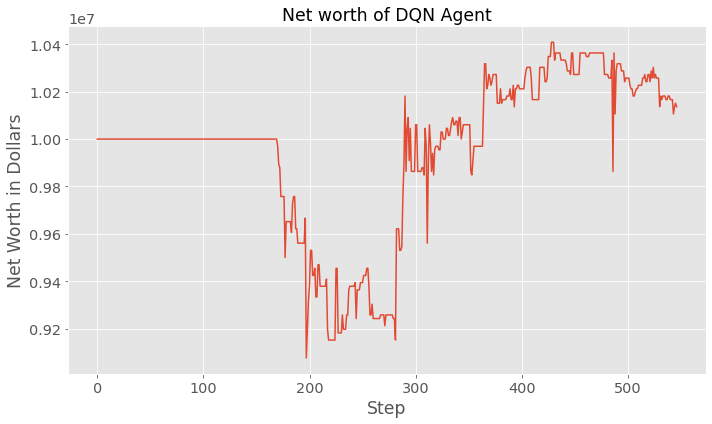

In [30]:
#Plot the networth
#dates = subset_data.index
plt.figure(figsize=(10, 6), tight_layout=True)
plt.plot(portfolio.performance.index, portfolio.performance['net_worth'], label="Net Worth")
plt.xlabel("Step")
plt.ylabel("Net Worth in Dollars")
plt.title("Net worth of DQN Agent")
plt.show()

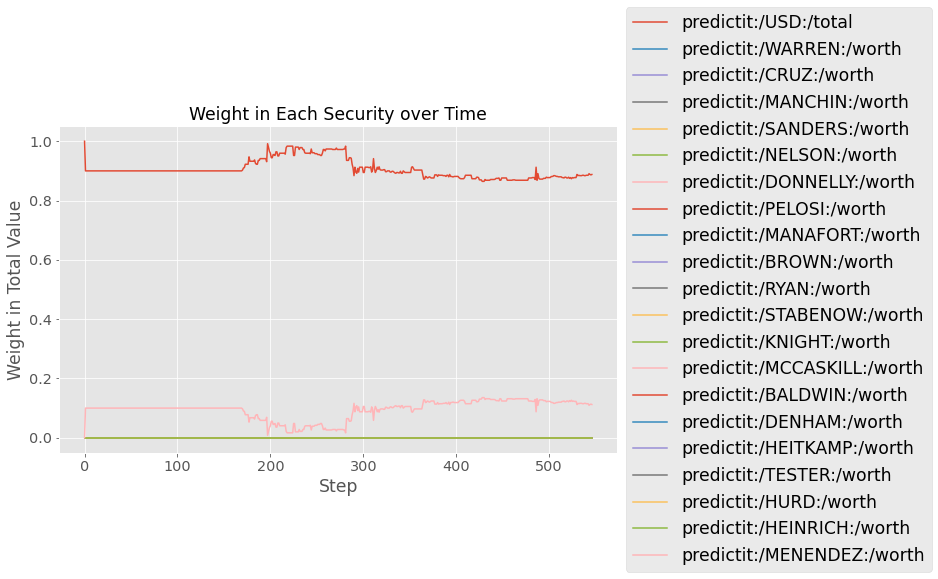

In [31]:
### Plot the total balance in each type of item
import seaborn as sns

ax = portfolio.weights.iloc[:,:].plot(figsize=(10, 6))
sns.set_palette(sns.color_palette('hls', 20))

plt.xlabel("Step")
plt.ylabel("Weight in Total Value")
plt.title("Weight in Each Security over Time")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

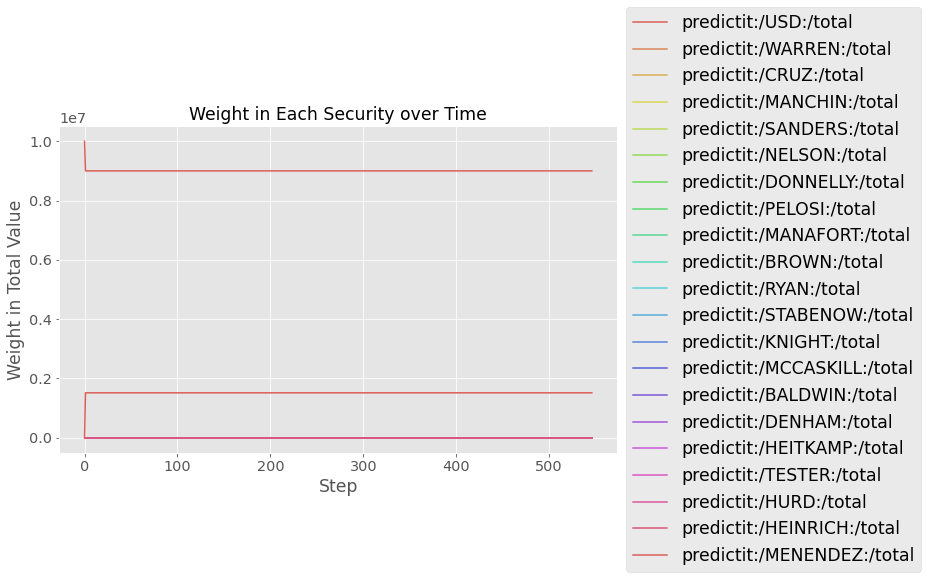

In [32]:
total_shares = portfolio.performance.loc[:, [("total" in name) for name in portfolio.performance.columns]]
#del total_shares["predictit:/USD:/total"]
total_shares.plot(figsize=(10, 6))

sns.set_palette(sns.color_palette('gist_rainbow', 20))

plt.xlabel("Step")
plt.ylabel("Weight in Total Value")
plt.title("Weight in Each Security over Time")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

In [36]:
total_balances = portfolio.performance.loc[:, [("total" in name) for name in portfolio.performance.columns]]
change_df = total_balances.dropna().pct_change()
change_df = change_df.replace([np.inf, -np.inf, np.nan], 0)
change_in_balances = change_df.iloc[-506].values
np.dot(change_in_balances, change_in_balances)

0.0

## Extra Stuff

In [ ]:
apath = "/Users/jasonfiacco/Documents/Yale/Senior/thesis/jasonfiacco-selectedmarkets-mytickers.xlsx"
df = pd.read_excel(apath, skiprows=2)
jason_tickers = df.iloc[:, 5].tolist()
descriptions = df.iloc[:, 1].tolist()

for ticker, description in zip(jason_tickers, descriptions):
    l = "{} = Instrument(\'{}\', 2, \'{}\')".format(ticker, ticker, description)
    print(l)

In [ ]:
import matplotlib.pyplot as plt
#closing_prices = test_data.loc[:, [("price_norm" in name) for name in test_data.columns]]
my_data = all_data[(pd.to_datetime(all_data.index)>= '08-02-2018')]
my_data["MANAFORT:close"].plot()


In [ ]:
closing_prices.plot(figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Closing prices of all markets")
plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.show()

In [ ]:
portfolio.performance[["predictit:/MANAFORT:/worth", "predictit:/MANAFORT:/total"]]